<a href="https://colab.research.google.com/github/PrzemyslawSarnacki/AirQualityPrediction/blob/master/data_analysis.ipynb" target="_parent">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a> 

## Wstępna obróbka i Analiza danych

Wczytanie potrzebnych bibliotek

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import warnings
import numpy as np


warnings.simplefilter('ignore')

%matplotlib inline

# Set major seaborn asthetics
sns.set("notebook", style='ticks', font_scale=1.0)

# Increase the quality of inline plots
mpl.rcParams['figure.dpi']= 500


Stwórzmy zmienne zawierające potrzebne nam w dalszej obróbce dane takie jak koordynaty miast oraz funkcję zamieniającą polskie znaki

In [ ]:
import unicodedata

def strip_accents(text):
    return ''.join(c for c in unicodedata.normalize('NFKD', text.lower().replace("ł","l")) if unicodedata.category(c) != 'Mn')

CITIES = ["Warszawa", "Kraków", "Poznań", "Katowice", "Białystok"]
COORDINATES = {
    "warszawa": {
        "latitude": 52.2297,
        "longitude": 21.0122
    },
    "krakow": {
        "latitude": 50.0647,
        "longitude": 19.9450
    },
    "poznan": {
        "latitude": 52.4064,
        "longitude": 16.9252
    },
    "katowice": {
        "latitude": 50.2649,
        "longitude": 19.0238
    },
    "bialystok": {
        "latitude": 53.1325,
        "longitude": 23.1688
    },
}
PARAMETERS = ['pm25', 'pm10', 'no2', 'so2', 'o3', 'co']

Po wczytaniu danych widzimy, że wymagają one obróbki

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/PrzemyslawSarnacki/AirQualityPrediction/master/data/airq_data_1.csv", index_col=0, parse_dates=True)

df.head()

warszawa warszawa.1  ...         bialystok.4        bialystok.5
NaN            pm25       pm10  ...                  o3                 co
date.local      NaN        NaN  ...                 NaN                NaN
2018-11-21      NaN        NaN  ...                41.2              296.8
2018-11-22      NaN        NaN  ...  27.695652173913043             320.75
2018-11-23      NaN        NaN  ...  25.083333333333332  313.2916666666667

[5 rows x 30 columns]

Uporządkujmy i obróbmy dane tak by nadawały się do dalszej analizy

In [ ]:
indices = [""] + [f".{i}" for i in range(1, 6)]
data = {}

for city in CITIES:
    data[strip_accents(city)] = pd.DataFrame(df, columns=[f"{strip_accents(city)}{item}" for item in indices])
    data[strip_accents(city)] = data[strip_accents(city)].rename(columns=data[strip_accents(city)].iloc[0]).drop(data[strip_accents(city)].index[0])
    data[strip_accents(city)] = data[strip_accents(city)].drop(index="date.local").astype(float).interpolate(method="linear")
    data[strip_accents(city)].index = pd.to_datetime(data[strip_accents(city)].index)




In [ ]:
data["warszawa"].tail()

pm25       pm10        no2       so2         o3           co
2020-12-18  37.777281  42.442982  29.465543  6.770435   6.868626  1334.217391
2020-12-19  36.421228  40.852895  23.945761  4.084348   8.846803  1185.043478
2020-12-20  30.318833  31.197000  17.121458  4.358333  18.062042   988.041667
2020-12-21  30.687833  32.746083  23.669479  5.507917  15.765789  1196.083333
2020-12-22  33.230105  34.139684  25.167763  4.876842  10.749707  1129.421053

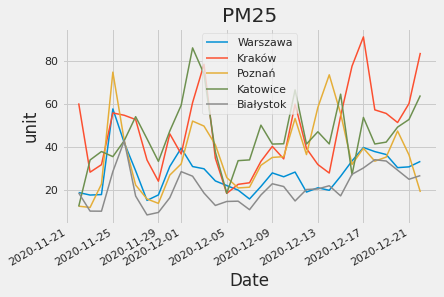

In [ ]:
def plot_cities(parameter, zoom):
    """
    Make plotting easier
    """
    plt.style.use('fivethirtyeight')

    fig, ax = plt.subplots()
    for city in CITIES:
        ax.plot(data[strip_accents(city)].tail(zoom).index, data[strip_accents(city)][parameter].tail(zoom) ,linewidth=1.5)

    ax.legend(CITIES)
    ax.set_title(parameter.upper())
    ax.set_xlabel("Date")
    ax.set_ylabel("unit")

    # Rotate and align the tick labels so they look better.
    fig.autofmt_xdate()

plot_cities("pm25", 31)

Porównywanie każdego miast na jednym wykresie zawierającym wartości poszczególnych nie jest najbardziej efektywną formą analizy dużej ilośći danych

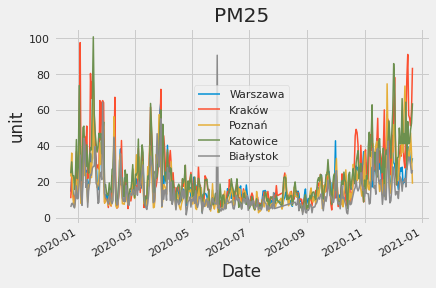

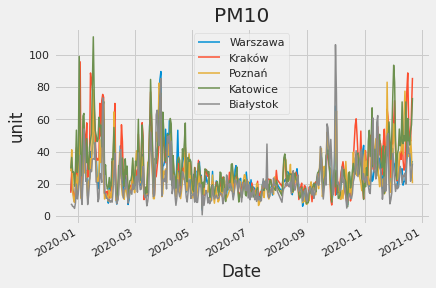

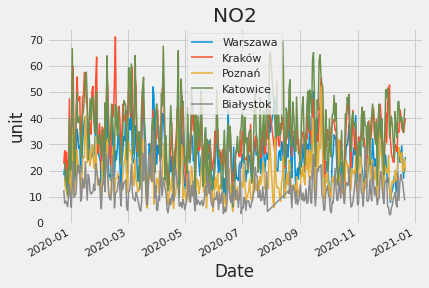

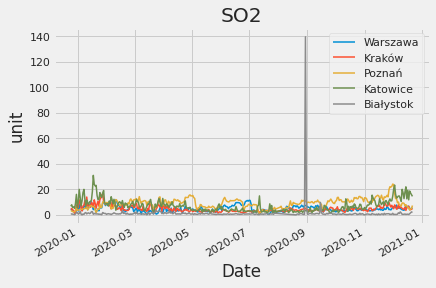

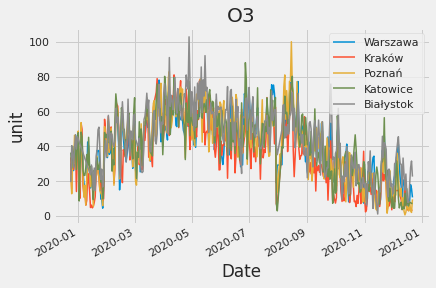

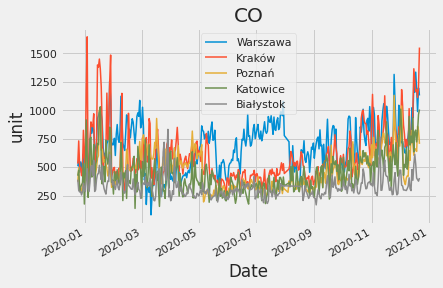

In [ ]:
for param in PARAMETERS:
    plot_cities(param, 365) 

Skupienie się w krótkich wycinkach czasowych również nie jest zbyt efektywne

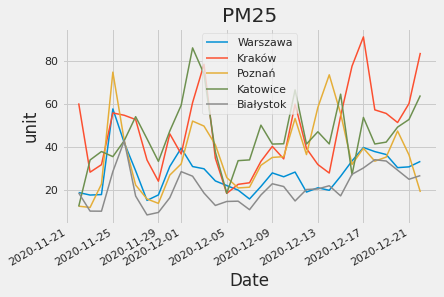

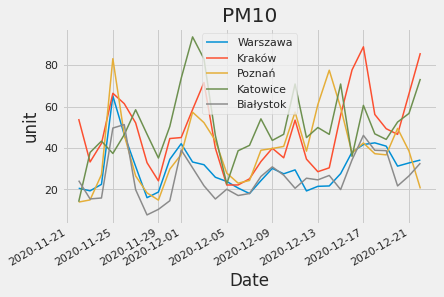

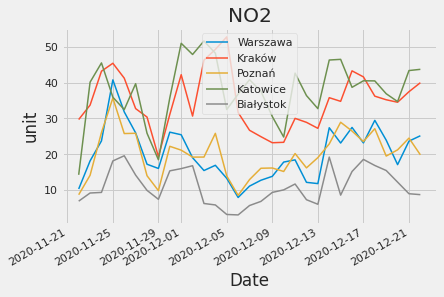

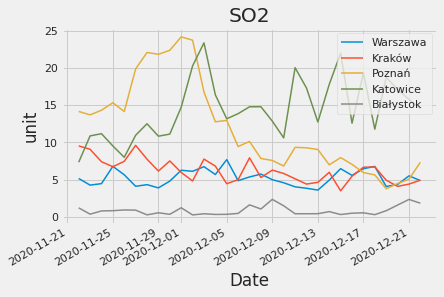

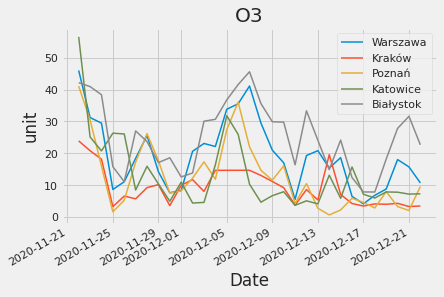

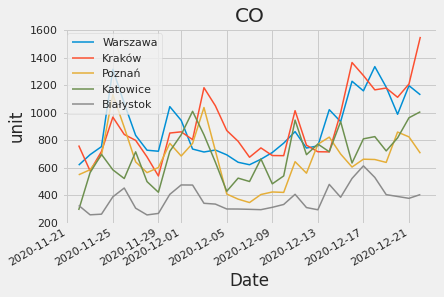

In [ ]:
for param in PARAMETERS:
    plot_cities(param, 31)

## Obliczenia Air Quality Index

Agencje rządowe wykorzystują indeks jakości powietrza do informowania opinii publicznej o aktualnym zanieczyszczeniu powietrza lub przewidywanym poziomie zanieczyszczenia. Jest to znacznie prostszy parametr do obrazowania jakości powietrza niż poszczególne parametry (na podstawie, których jest obliczany) i jak zobaczymy dalej pomimo swojej prostoty jest bardzo dobrym odnośnikiem i indykatorem o tym jak powietrze jest zanieczyszczone

Zadeklarujemy teraz formuły do obliczenia AQI dla poszczególnych parametrów  

In [ ]:
def calculate_o3_aqi(concentration):
    if concentration<=50:
        aqi = concentration*50/50
    elif concentration>50 and concentration<=100:
        aqi = 50+(concentration-50)*50/50
    elif concentration>100 and concentration<=168:
        aqi = 100+(concentration-100)*100/68
    elif concentration>168 and concentration<=208:
        aqi = 200+(concentration-168)*(100/40)
    elif concentration>208 and concentration<=748:
        aqi = 300+(concentration-208)*(100/539)
    elif concentration>748:
        aqi = 400+(concentration-400)*(100/539)
    else:
        aqi = 0
    return aqi

    
def calculate_co_aqi(concentration):
    if concentration<=1:
        aqi = concentration*50/1
    elif concentration>1 and concentration<=2:
        aqi = 50+(concentration-1)*50/1
    elif concentration>2 and concentration<=10:
        aqi = 100+(concentration-2)*100/8
    elif concentration>10 and concentration<=17:
        aqi = 200+(concentration-10)*(100/7)
    elif concentration>17 and concentration<=34:
        aqi = 300+(concentration-17)*(100/17)
    elif concentration>34: 
        aqi = 400+(concentration-34)*(100/17)
    else:
        aqi = 0
    return aqi


def calculate_no2_aqi(concentration):
    if concentration<=40:
        aqi = concentration*50/40
    elif concentration>40 and concentration<=80:
        aqi = 50+(concentration-40)*50/40
    elif concentration>80 and concentration<=180:
        aqi = 100+(concentration-80)*100/100    
    elif concentration>180 and concentration<=280:
        aqi = 200+(concentration-180)*(100/100)
    elif concentration>280 and concentration<=400:
        aqi = 300+(concentration-280)*(100/120)
    elif concentration>400:
        aqi = 400+(concentration-400)*(100/120)
    else:
        aqi = 0
    return aqi


# SO2
def calculate_so2_aqi(concentration):
    if concentration<=40:
        aqi = concentration*50/40
    elif concentration>40 and concentration<=80:
        aqi = 50+(concentration-40)*50/40
    elif concentration>80 and concentration<=380:
        aqi = 100+(concentration-80)*100/300
    elif concentration>380 and concentration<=800:
        aqi = 200+(concentration-380)*(100/420)
    elif concentration>800 and concentration<=1600:
        aqi = 300+(concentration-800)*(100/800)
    elif concentration>1600: 
        aqi = 400+(concentration-1600)*(100/800)
    else:
        aqi = 0
    return aqi

# PM2.5
def calculate_pm25_aqi(concentration):
    if concentration<=30:
        aqi = concentration*50/30
    elif concentration>30 and concentration<=60: 
        aqi = 50+(concentration-30)*50/30
    elif concentration>60 and concentration<=90: 
        aqi = 100+(concentration-60)*100/30
    elif concentration>90 and concentration<=120: 
        aqi = 200+(concentration-90)*(100/30)
    elif concentration>120 and concentration<=250: 
        aqi = 300+(concentration-120)*(100/130)
    elif concentration>250: 
        aqi = 400+(concentration-250)*(100/130)
    else:
        aqi = 0
    return aqi

def calculate_pm10_aqi(concentration):
    if concentration<=50:
        aqi = concentration
    elif concentration>50 and concentration<=100: 
        aqi = concentration
    elif concentration>100 and concentration<=250: 
        aqi = 100+(concentration-100)*100/150
    elif concentration>250 and concentration<=350: 
        aqi = 200+(concentration-250)
    elif concentration>350 and concentration<=430: 
        aqi = 300+(concentration-350)*(100/80)
    elif concentration>430:
        aqi = 400+(concentration-430)*(100/80)
    else:
        aqi = 0
    return aqi


def calculate_aqi(row):
    sub_aqis = [
                calculate_pm25_aqi(row["pm25"]),
                calculate_pm10_aqi(row["pm10"]),
                calculate_no2_aqi(row["no2"]),
                calculate_so2_aqi(row["so2"]),
                calculate_o3_aqi(row["o3"]),
                ]
    aqi = max(sub_aqis)
    return aqi


def categorize_aqi(aqi):
    return "BAD"

Obliczmy wg. powyższych formuł aqi i dodajmy dodatkową kolumnę dla tego parametru. Przy okazji dodamy kolumny wskazujące na koordynaty badanych miast

In [ ]:
for city in CITIES:
    data[strip_accents(city)]["aqi"] = data[strip_accents(city)].apply(calculate_aqi, axis=1).astype(float)
    data[strip_accents(city)]["latitude"] = COORDINATES[strip_accents(city)]["latitude"]
    data[strip_accents(city)]["longitude"] = COORDINATES[strip_accents(city)]["longitude"]


Porównanie AQI na przełomie listopada / grudnia. Jak widać wartości szczytowe w tym okresie posiadają miasta obiegowo znane z niskiej jakości powietrza

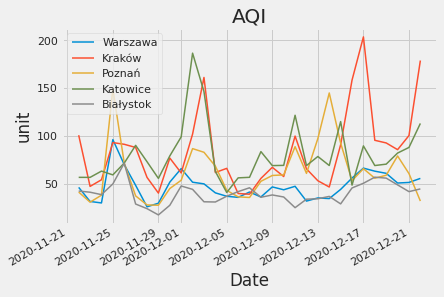

In [ ]:
plot_cities("aqi", 31)

Stwórzmy dodatkowe zmienne zawierające uśredmiome wartości w poszczególnych miesiącach 

In [ ]:
maps = pd.concat([data[strip_accents(city)].resample('M').mean().tail(12) for city in CITIES])
cities_by_month = pd.concat([data[strip_accents(city)]["aqi"].resample('M').mean().tail(12) for city in CITIES], axis=1, keys=[f"aqi_{strip_accents(city)}" for city in CITIES])

Jeśli porównamy stopień korelacji poszczególnych parametrów widzimy, że pm10 i pm25 okazują się być najbardziej skorelowane z aqi. Co pokazuje, że AQI w głównej mierze skupia się na uwzględnieniu najbardziej istotnych parametrów jednocześnie biorąc te mniej istotne również pod uwagę w wypadku osiągnięciu przez nie szczególnie niebezpiecznych wartości 

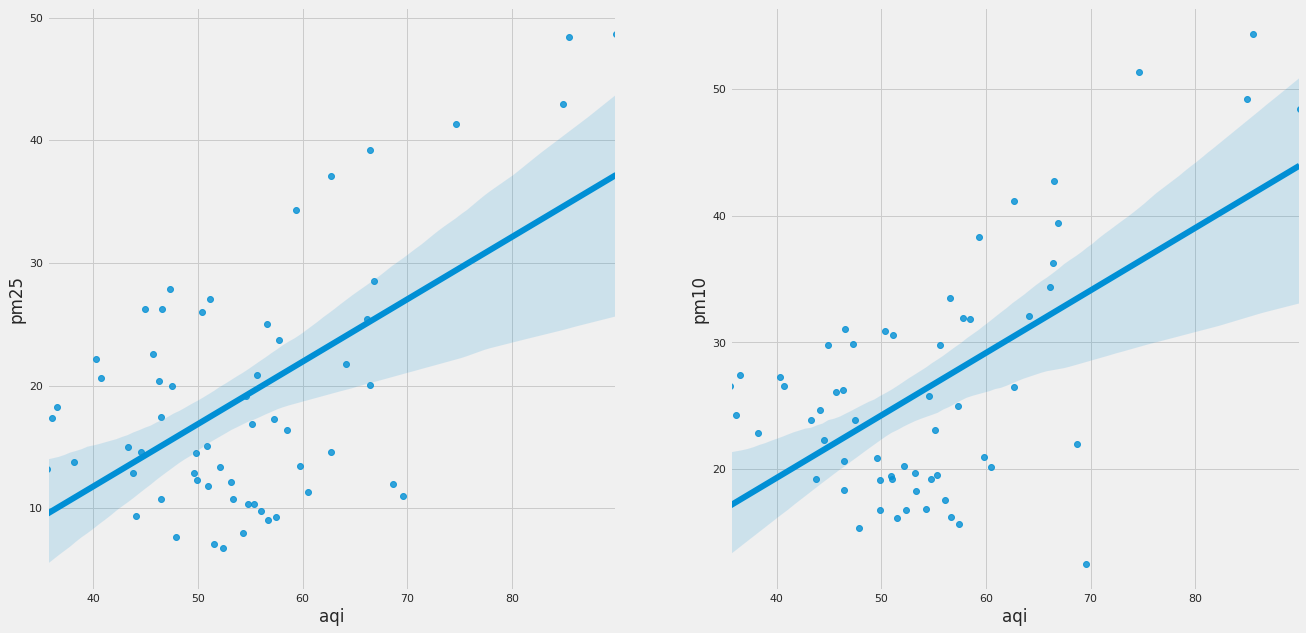

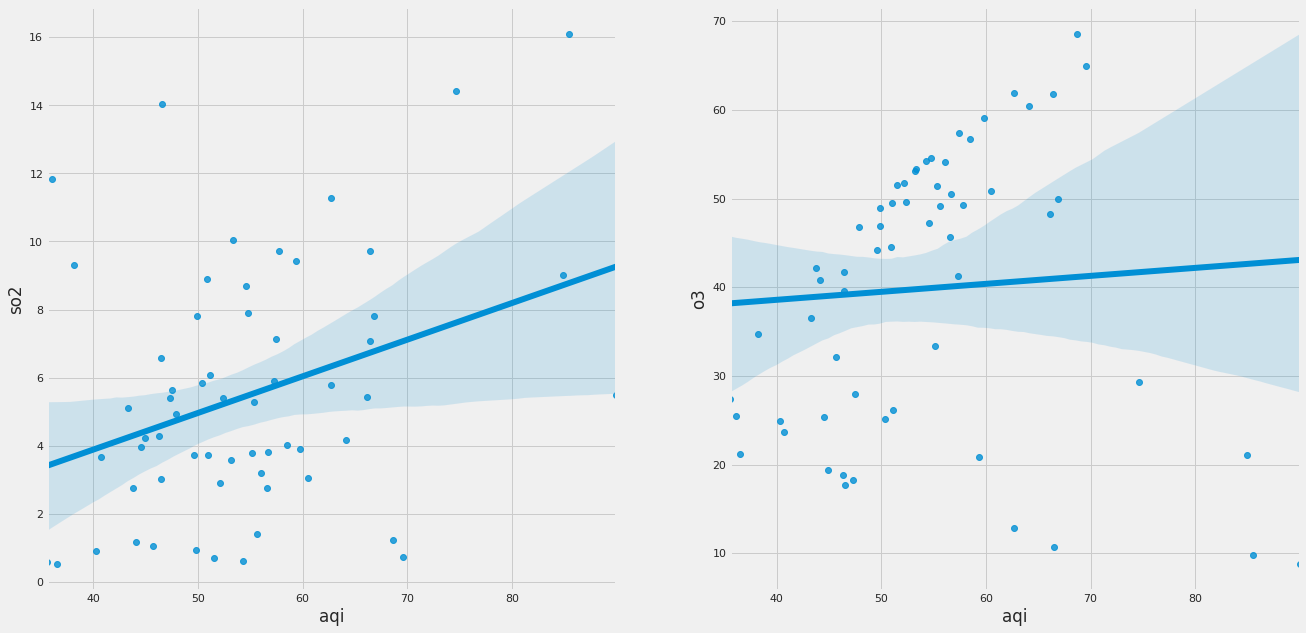

In [ ]:
fig,(ax, ax1) = plt.subplots(1,2, figsize=(20,10))
sns.regplot(data=maps[["aqi","pm25"]], x="aqi", y="pm25", ax=ax)
sns.regplot(data=maps[["aqi","pm10"]], x="aqi", y="pm10", ax=ax1)

fig,(ax2, ax3) = plt.subplots(1,2, figsize=(20,10))
sns.regplot(data=maps[["aqi","so2"]], x="aqi", y="so2", ax=ax2)
sns.regplot(data=maps[["aqi","o3"]], x="aqi", y="o3", ax=ax3)

plt.show()

Poniżej możemy w sposób interaktywny zobaczyć jak zmienia się AQI w przestrzeni czasu na mapie 

In [ ]:
import plotly.express as px
fig = px.scatter_mapbox(maps, lat="latitude", lon="longitude", color="aqi", size="aqi",
                  color_continuous_scale=px.colors.diverging.RdYlGn[::-1], size_max=25, zoom=4.5,
                  mapbox_style="carto-positron",
                  animation_frame=maps.index.astype(str))
fig.show(renderer="")


Poniżej widzimy mapę cieplną pokazującą nam jak na przestrzeni miesięcy zmienia się dany parametr w dannych miastach. Jak widzimy najniższe wartości osiągają miasta Kraków oraz Katowice i wartości szczytowe są osiągane w miesiącach grudzień i styczeń). Wzrosty AQI notowane są również w miesiącach Marzec oraz Kwiecień. W pozostałych miesiącach poziom tego wskaźnika pozostaje stabilny.

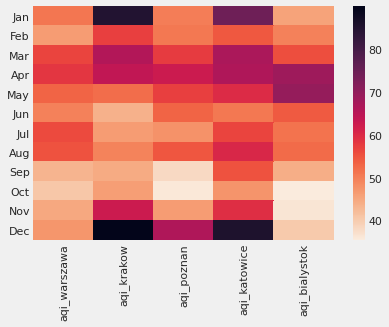

In [ ]:
month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
sns.heatmap(cities_by_month, yticklabels=month_labels, cmap=sns.cm.rocket_r)

# Predykcja AQI przy pomocy Machine Learning

Możliwa jest predykcja parametru AQI przy pomocy prostego modelu uczenia maszynowego (w tym przypadku jest to  Drzewo Decyzyjne) na podstawie dostępnych parametrów

W tym celu kolejno dzielimy dane na treningowe i testowe, dopasowujemy model oraz go trenujemy.

Po wykonaniu testów widzimy, że poziom błędów absolutnych oraz współczynnika błędu wskazują na wysoką dokładność danego modelu

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

X = data["bialystok"][PARAMETERS]
y = data["bialystok"]["aqi"]

train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)

aqi_model = DecisionTreeRegressor(random_state=1)
aqi_model.fit(train_X, train_y)
preds_val = aqi_model.predict(val_X)
mae = mean_absolute_error(val_y, preds_val)

val_war = data["warszawa"][PARAMETERS].tail(20)
val_yw = data["warszawa"]["aqi"].tail(20)
preds_war = aqi_model.predict(val_war)
mae_war = mean_absolute_error(val_yw, preds_war)

print(f"MAE względem danych testowych: {mae}\nMAE względem danych z innej serii: {mae_war}")
print(f"Coeff względem danych testowych: {aqi_model.score(val_X, val_y)}\nCoeff względem danych z innej serii: {aqi_model.score(val_war, val_yw)}")

MAE względem danych testowych: 1.3787726621268692
MAE względem danych z innej serii: 1.4238926034274109
Coeff względem danych testowych: 0.8575204798743771
Coeff względem danych z innej serii: 0.9381698394297131


Zapisujemy model do pliku w celu wykorzystania go w przyszłości

In [ ]:
# dump model in order to reuse it in the future
import joblib
joblib.dump(aqi_model, 'aqi.joblib') 


['aqi.joblib']

# Prognozowanie przy pomocy Deep Learning

Teraz podejdziemy do problemu prognozy przy pomocy klasycznego podejścia do zastosowania Deep Learning do prognozy szeregów czasowych

Odpowiednio transformujemy dane i dzielimy je na testowe i treningowe

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, GRU, Embedding
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.backend import square, mean


features = PARAMETERS.copy()

shift_days = 1
shift_steps = shift_days * 24  # Number of hours.
df_targets = data["katowice"][features].shift(-shift_steps)

X = data["katowice"].index.dayofyear.values[0:-shift_steps]
y = df_targets.values[:-shift_steps]
X = X.reshape(-1 ,1)

train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1, test_size=0.1, train_size=0.9, shuffle=True)

num_data = len(X)
num_train = len(train_X)

num_x_signals = X.shape[1]
num_y_signals = y.shape[1]

x_scaler = MinMaxScaler()

x_train_scaled = x_scaler.fit_transform(train_X)
x_test_scaled = x_scaler.transform(val_X)

y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(train_y)
y_test_scaled = y_scaler.transform(val_y)



Deklarujemy funkcję do tworzenia partii danych i zastosowujemy ją na naszych danych

In [ ]:
def batch_generator(batch_size, sequence_length):
    """
    Generator function for creating random batches of training-data.
    """

    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, sequence_length, num_x_signals)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, sequence_length, num_y_signals)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(num_train - sequence_length)
            
            # Copy the sequences of data starting at this index.
            x_batch[i] = x_train_scaled[idx:idx+sequence_length]
            y_batch[i] = y_train_scaled[idx:idx+sequence_length]
        
        yield (x_batch, y_batch)

In [ ]:
batch_size = 256
sequence_length = 365
generator = batch_generator(batch_size=batch_size,
                            sequence_length=sequence_length)

x_batch, y_batch = next(generator)


Nasza przykładowa partia wygląda następująco. Możemy zauważyć, że dane w tym przypadku zostały zeskalowane (zawierają się w przedziale 0 - 1)

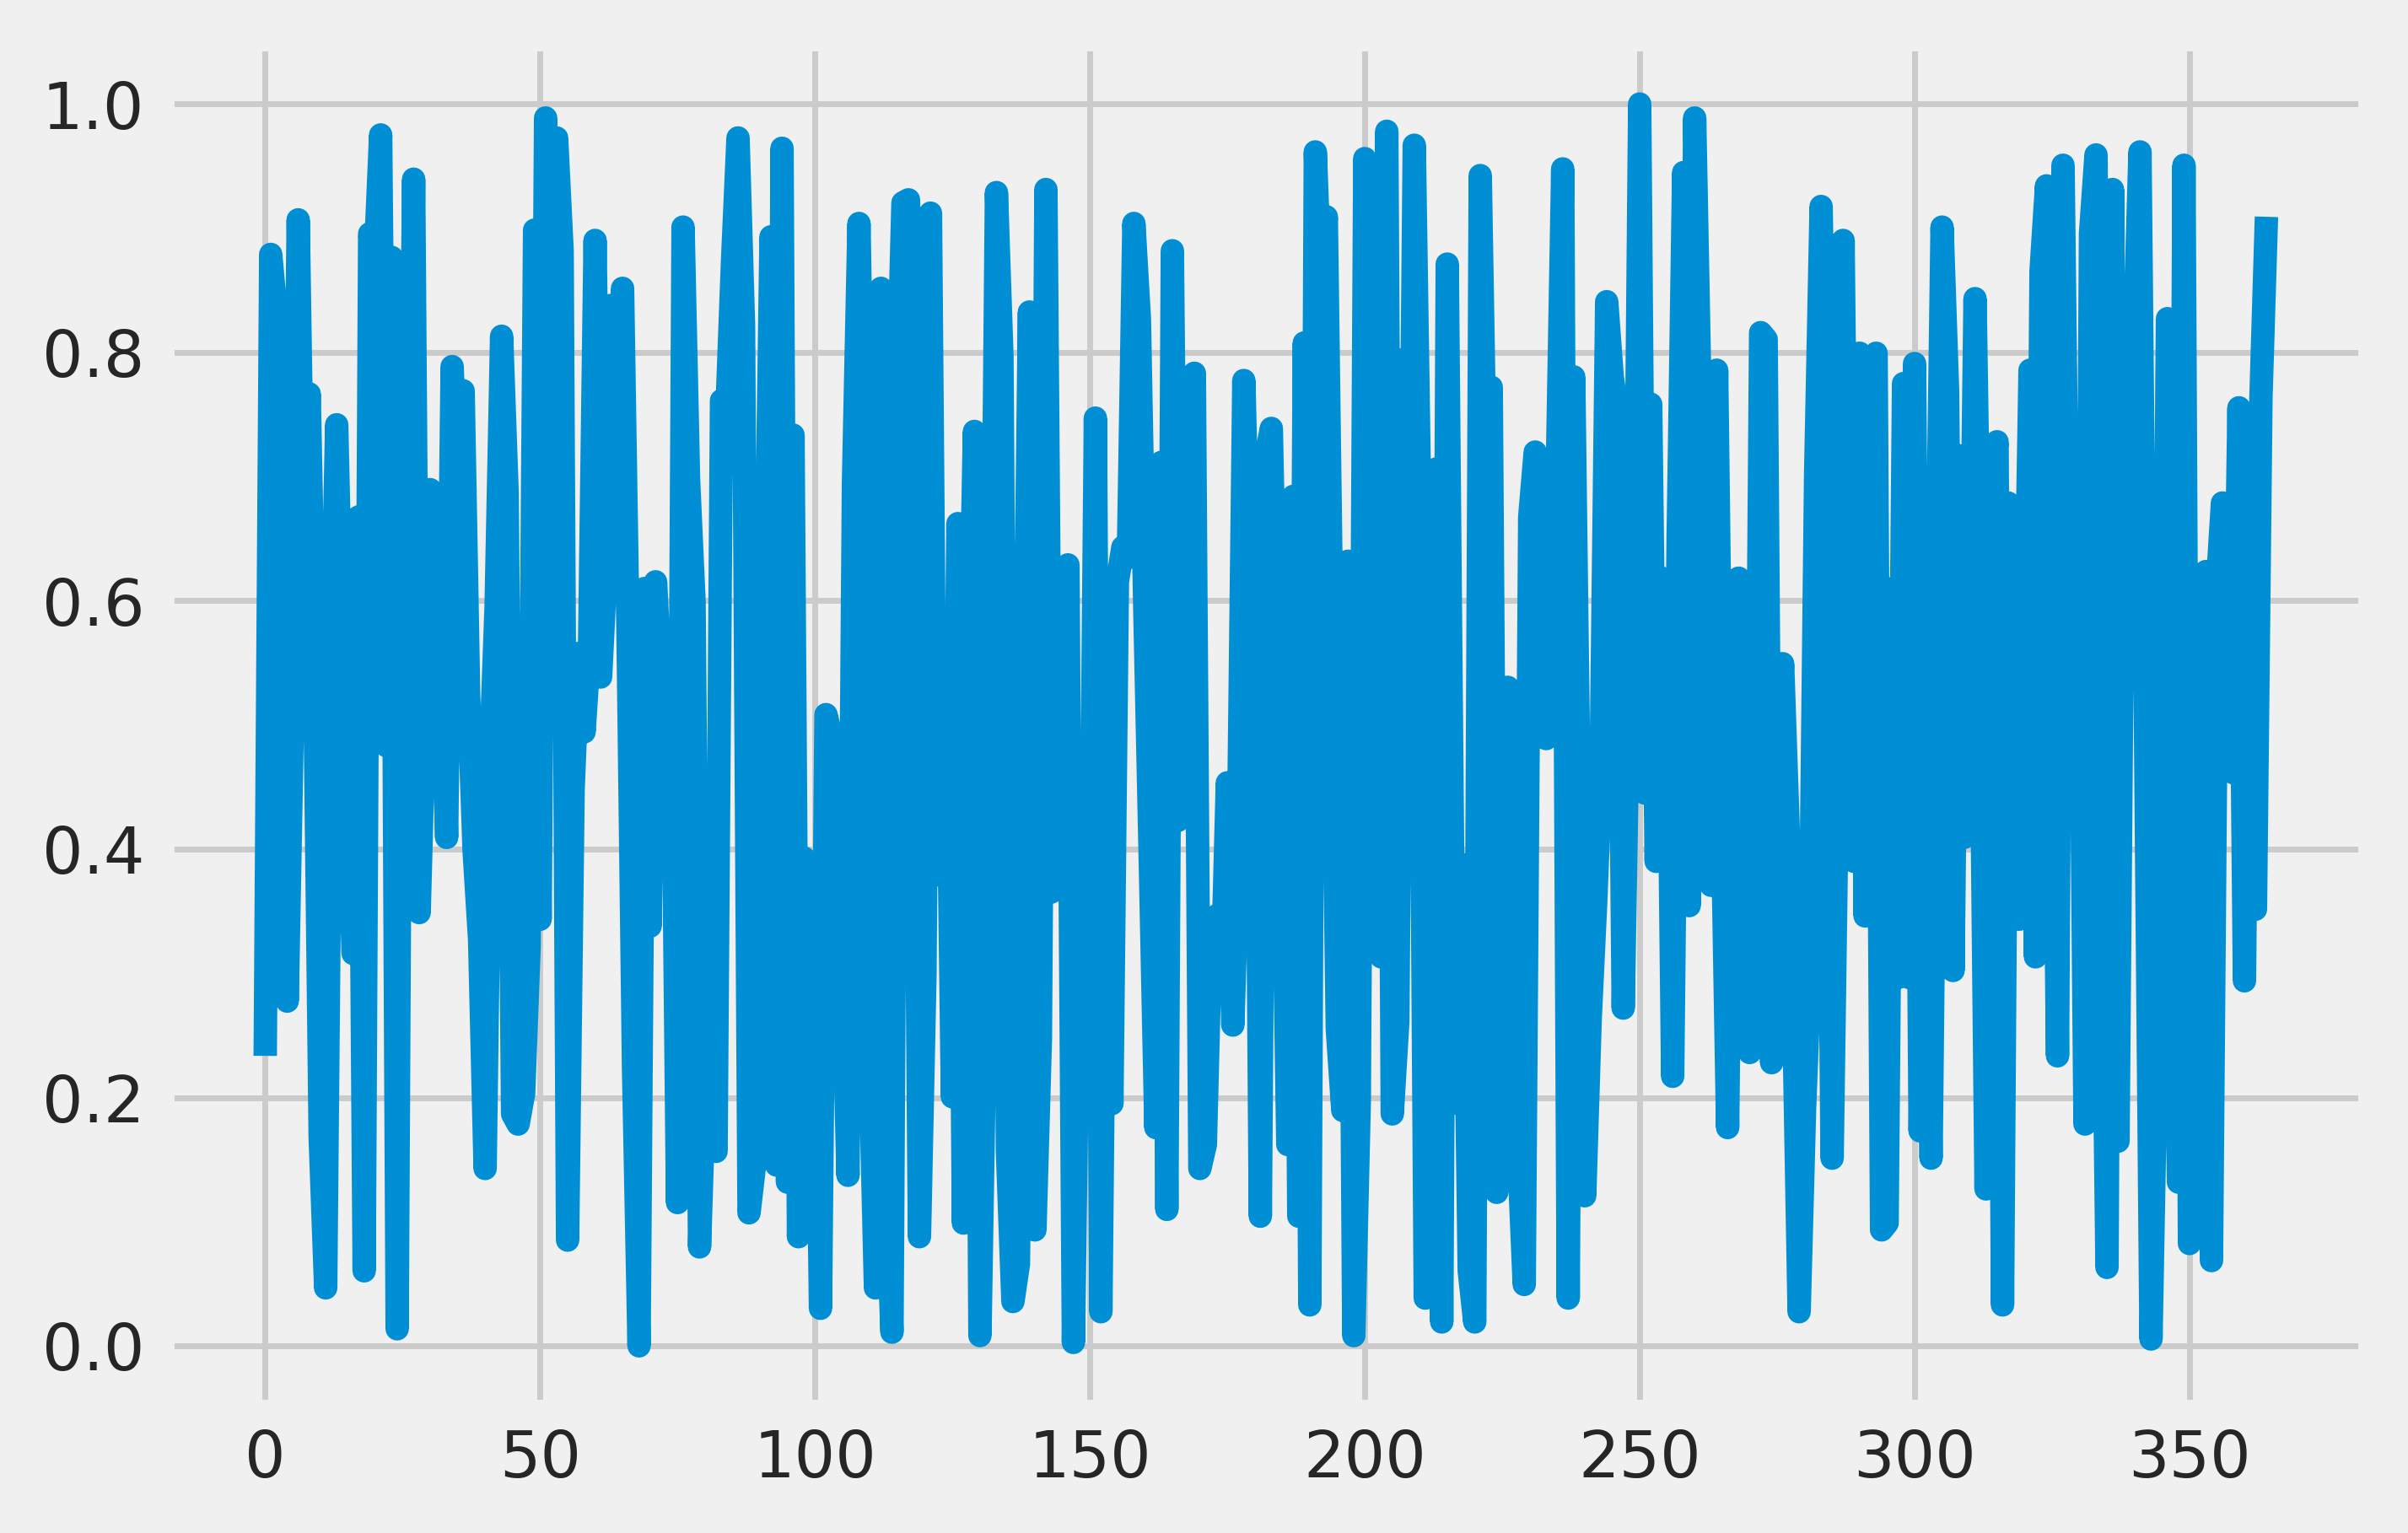

In [ ]:
batch = 0   # First sequence in the batch.
signal = 0  # First signal from the 20 input-signals.
seq = x_batch[batch, :, signal]
plt.plot(seq)

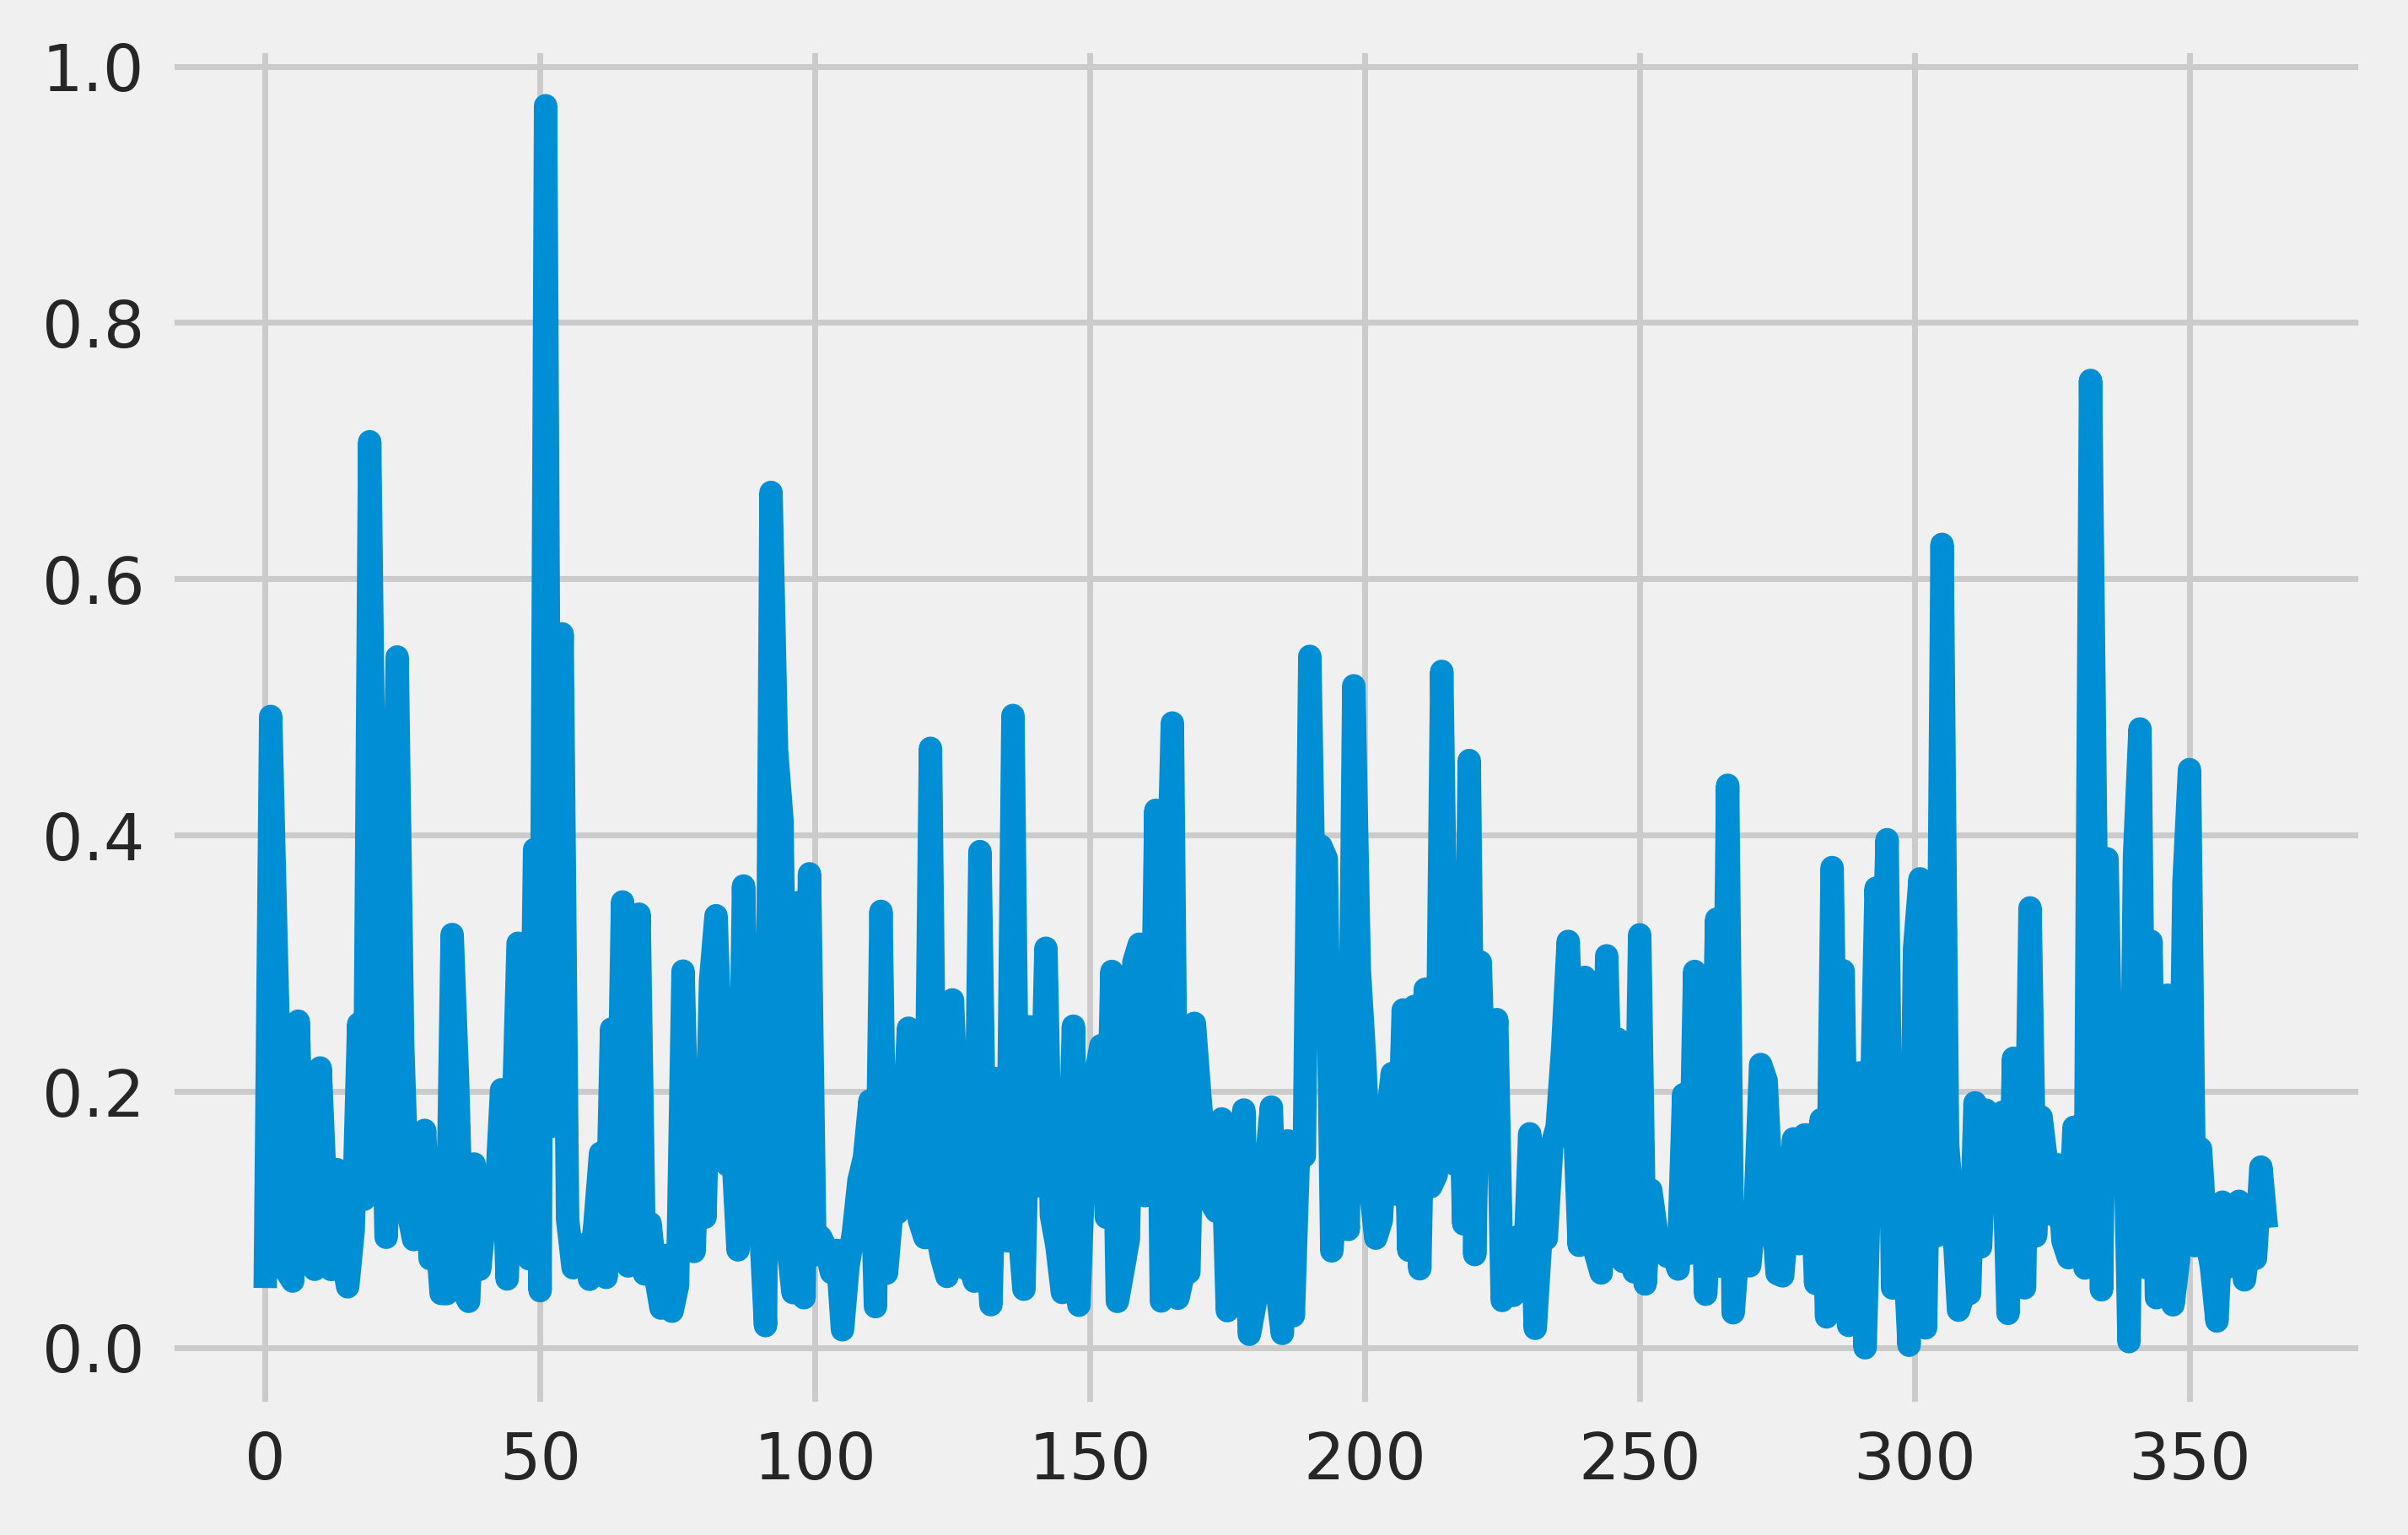

In [ ]:
seq = y_batch[batch, :, signal]
plt.plot(seq)

In [ ]:
validation_data = (np.expand_dims(x_test_scaled, axis=0),
                   np.expand_dims(y_test_scaled, axis=0))

Deklarujemy funkcję do pomiaru błędu średniokwadratowego oraz budujemy model, który składa się z warstwy GRU (Gated recurrent unit) oraz Dense 

In [ ]:
def loss_mse_warmup(y_true, y_pred):
    """
    Calculate the Mean Squared Error between y_true and y_pred,
    but ignore the beginning "warmup" part of the sequences.
    
    y_true is the desired output.
    y_pred is the model's output.
    """

    # The shape of both input tensors are:
    # [batch_size, sequence_length, num_y_signals].

    # Ignore the "warmup" parts of the sequences
    # by taking slices of the tensors.
    y_true_slice = y_true[:, warmup_steps:, :]
    y_pred_slice = y_pred[:, warmup_steps:, :]

    # These sliced tensors both have this shape:
    # [batch_size, sequence_length - warmup_steps, num_y_signals]

    # Calculat the Mean Squared Error and use it as loss.
    mse = mean(square(y_true_slice - y_pred_slice))
    
    return mse

model = Sequential([GRU(units=512,
              return_sequences=True,
              input_shape=(None, num_x_signals,)),
              Dense(num_y_signals, activation='sigmoid'),
              ])

warmup_steps = 50
optimizer = RMSprop(lr=1e-3)
model.compile(loss=loss_mse_warmup, optimizer=optimizer)
model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_2 (GRU)                  (None, None, 512)         791040    
_________________________________________________________________
dense_2 (Dense)              (None, None, 6)           3078      
Total params: 794,118
Trainable params: 794,118
Non-trainable params: 0
_________________________________________________________________


In [ ]:
path_checkpoint = '23_checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)
callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=5, verbose=1)
callback_tensorboard = TensorBoard(log_dir='./23_logs/',
                                   histogram_freq=0,
                                   write_graph=False)
callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-4,
                                       patience=0,
                                       verbose=1)
callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_tensorboard,
             callback_reduce_lr]

Trenujemy model na naszych danych treningowych. W celu zwiększenia generalizacji modelu liczba epok jest równa 1

In [ ]:
# %%time
model.fit(x=generator,
          epochs=1,
          steps_per_epoch=100,
          validation_data=validation_data,
          callbacks=callbacks)


100/100 [==============================] - 1218s 12s/step - loss: 0.0352 - val_loss: 0.0220

Epoch 00001: val_loss improved from inf to 0.02195, saving model to 23_checkpoint.keras


Jak widzimy straty bezwzględne modelu są niskie

In [ ]:
try:
    model.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

result = model.evaluate(x=np.expand_dims(x_test_scaled, axis=0),
                        y=np.expand_dims(y_test_scaled, axis=0))

print("loss (test-set):", result)

1/1 [==============================] - 0s 36ms/step - loss: 0.0220
loss (test-set): 0.021952450275421143


Deklarujemy funkcję, która zwizualizuje prognozy (odpowiednio z powrotem przekształcone) oraz porówna je do danych testowych

In [ ]:
def plot_comparison(start_idx, length=100, train=True):
    """
    Plot the predicted and true output-signals.
    
    :param start_idx: Start-index for the time-series.
    :param length: Sequence-length to process and plot.
    :param train: Boolean whether to use training- or test-set.
    """
    
    if train:
        # Use training-data.
        x = x_train_scaled
        y_true = train_y
    else:
        # Use test-data.
        x = x_test_scaled
        y_true = val_y
    
    # End-index for the sequences.
    end_idx = start_idx + length
    
    # Select the sequences from the given start-index and
    # of the given length.
    x = x[start_idx:end_idx]
    y_true = y_true[start_idx:end_idx]
    
    # Input-signals for the model.
    x = np.expand_dims(x, axis=0)

    # Use the model to predict the output-signals.
    y_pred = model.predict(x)
    
    # The output of the model is between 0 and 1.
    # Do an inverse map to get it back to the scale
    # of the original data-set.
    y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])
    
    # For each output-signal
    for signal in range(len(features)):
        # Get the output-signal predicted by the model.
        signal_pred = y_pred_rescaled[:, signal]
        
        # Get the true output-signal from the data-set.
        signal_true = y_true[:, signal]

        # Make the plotting-canvas bigger.
        plt.figure(figsize=(15,5))
        
        # Plot and compare the two signals.
        plt.plot(signal_true, label='true')
        plt.plot(signal_pred, label='pred')
        
        # Plot grey box for warmup-period.
        p = plt.axvspan(0, warmup_steps, facecolor='black', alpha=0.15)
        
        # Plot labels etc.
        plt.ylabel(features[signal])
        plt.legend()
        plt.show()

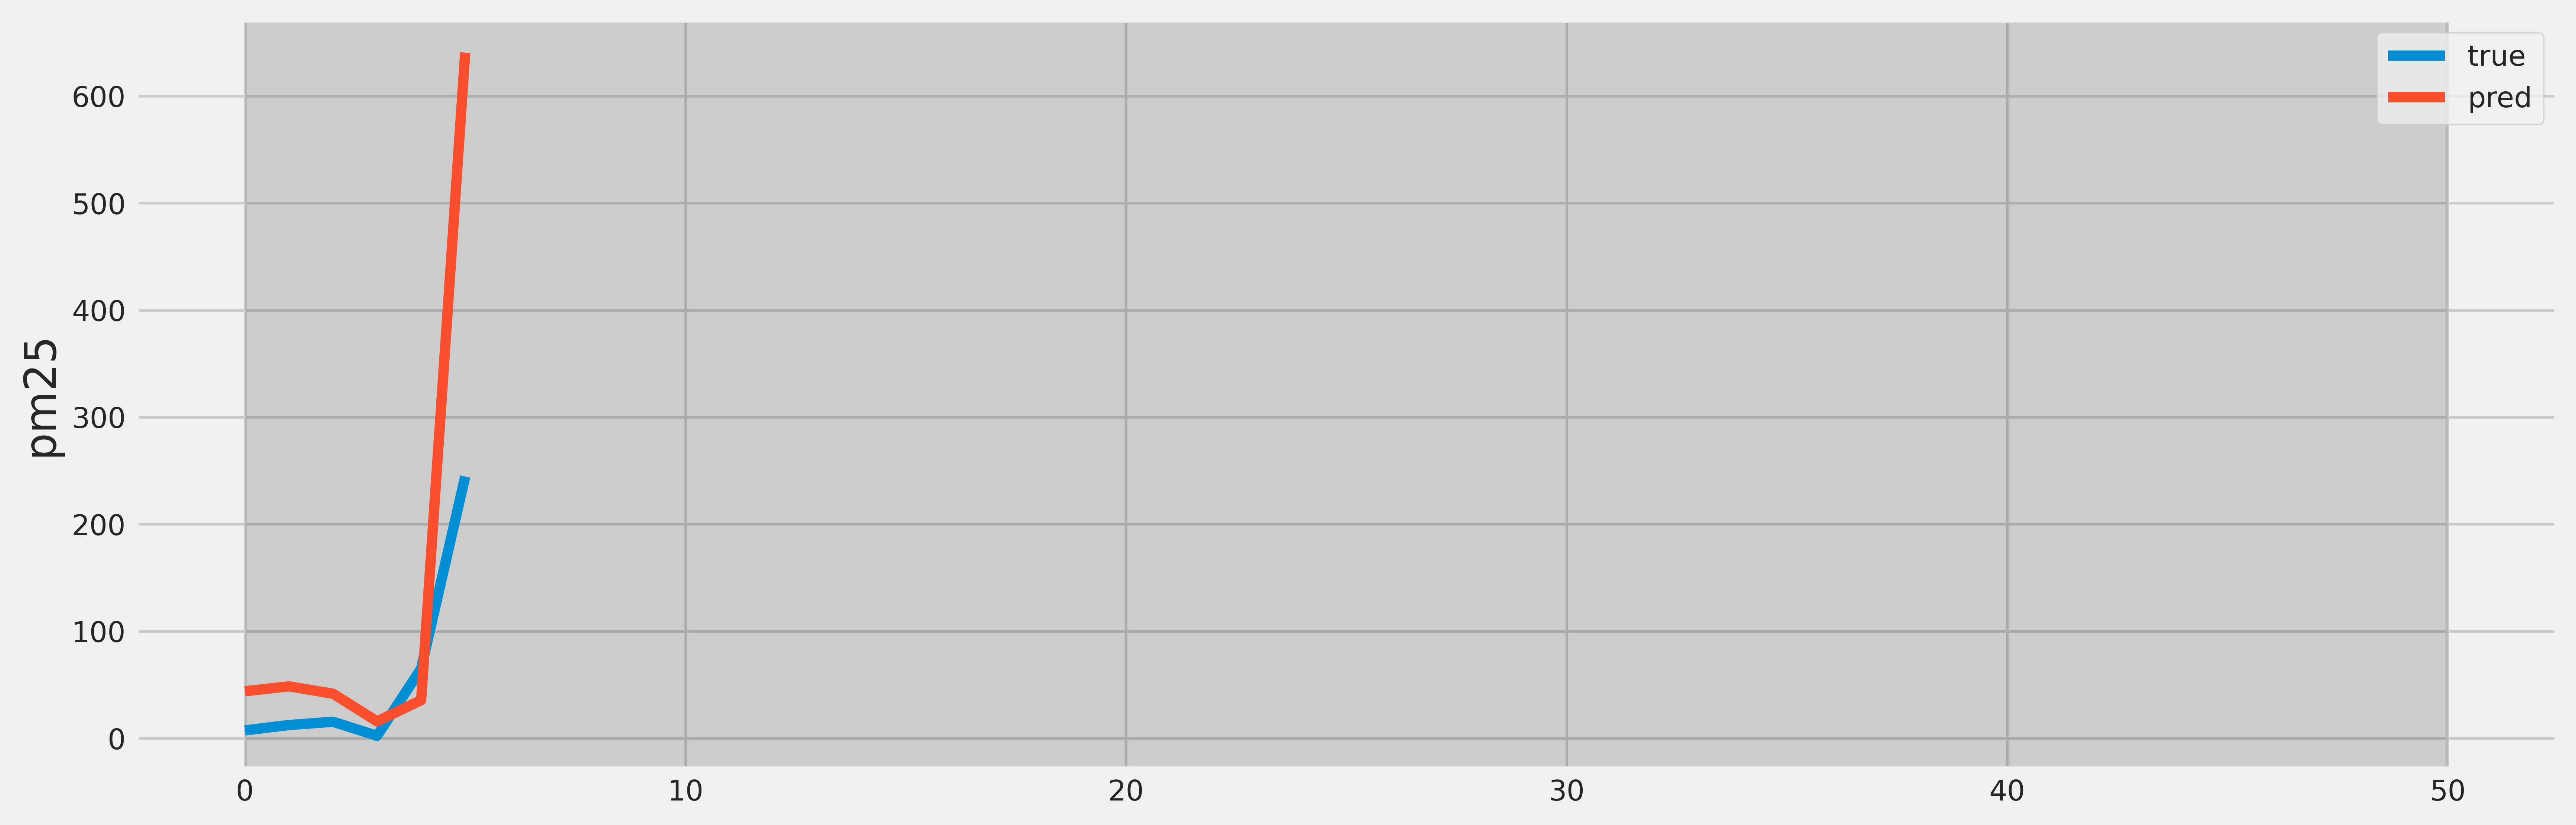

In [ ]:
x = x_train_scaled[0:100]
y_true = val_y[0:100]

# Input-signals for the model.
x = np.expand_dims(x, axis=0)

# Use the model to predict the output-signals.
y_pred = model.predict(x)
y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])

plt.figure(figsize=(15,5))
# Plot and compare the two signals.
plt.plot(y_true[2], label='true')
plt.plot(y_pred_rescaled[2], label='pred')

# Plot grey box for warmup-period.
p = plt.axvspan(0, warmup_steps, facecolor='black', alpha=0.15)

# Plot labels etc.
plt.ylabel(features[signal])
plt.legend()
plt.show()

Jak widzimy model ma pewną zdolność do przewidywania wartości oraz generalizacji danych, lecz sprawdza się najbardziej w przewidywaniu wartości parametrów CO oraz O3, czyli z punktu widzenia AQI niezbyt przydatnych. W celu pozyskania efektywnych prognoz potrzebujemy innego podejścia

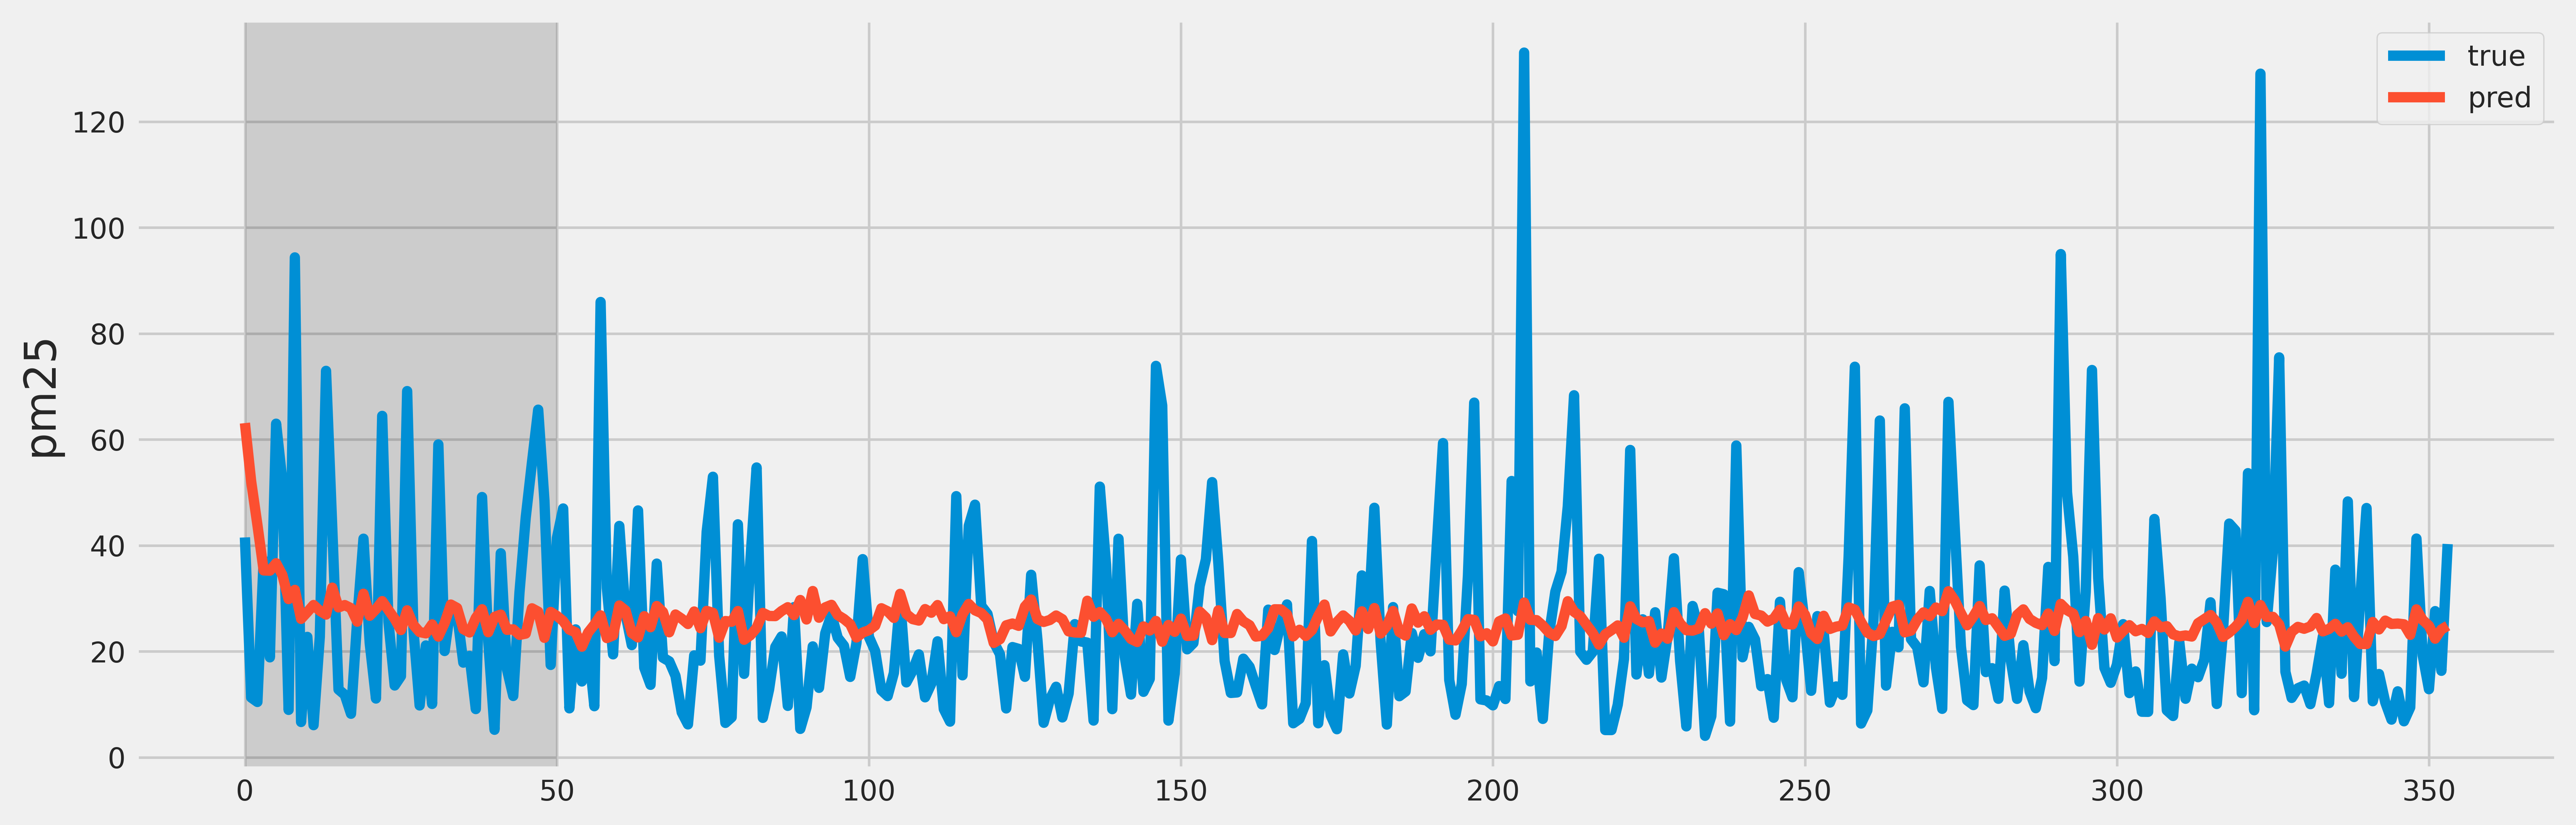

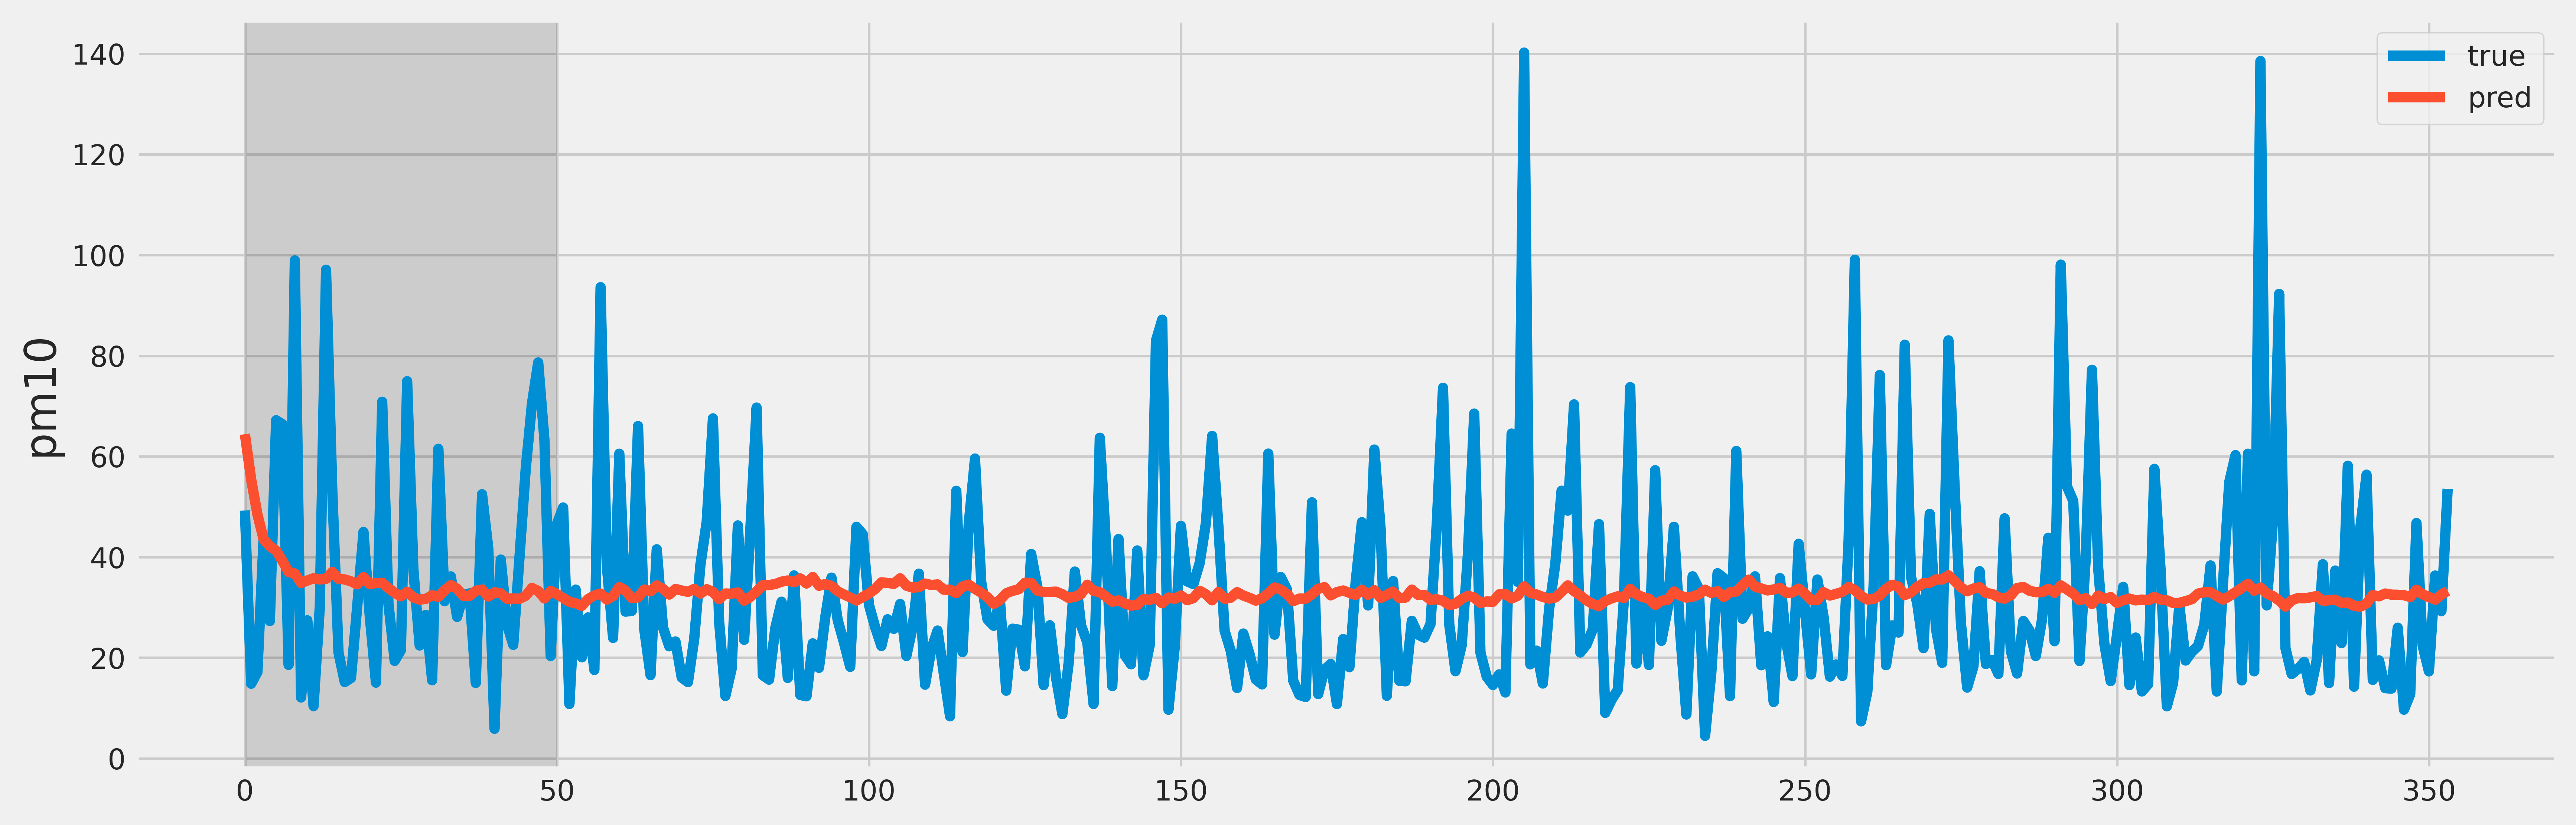

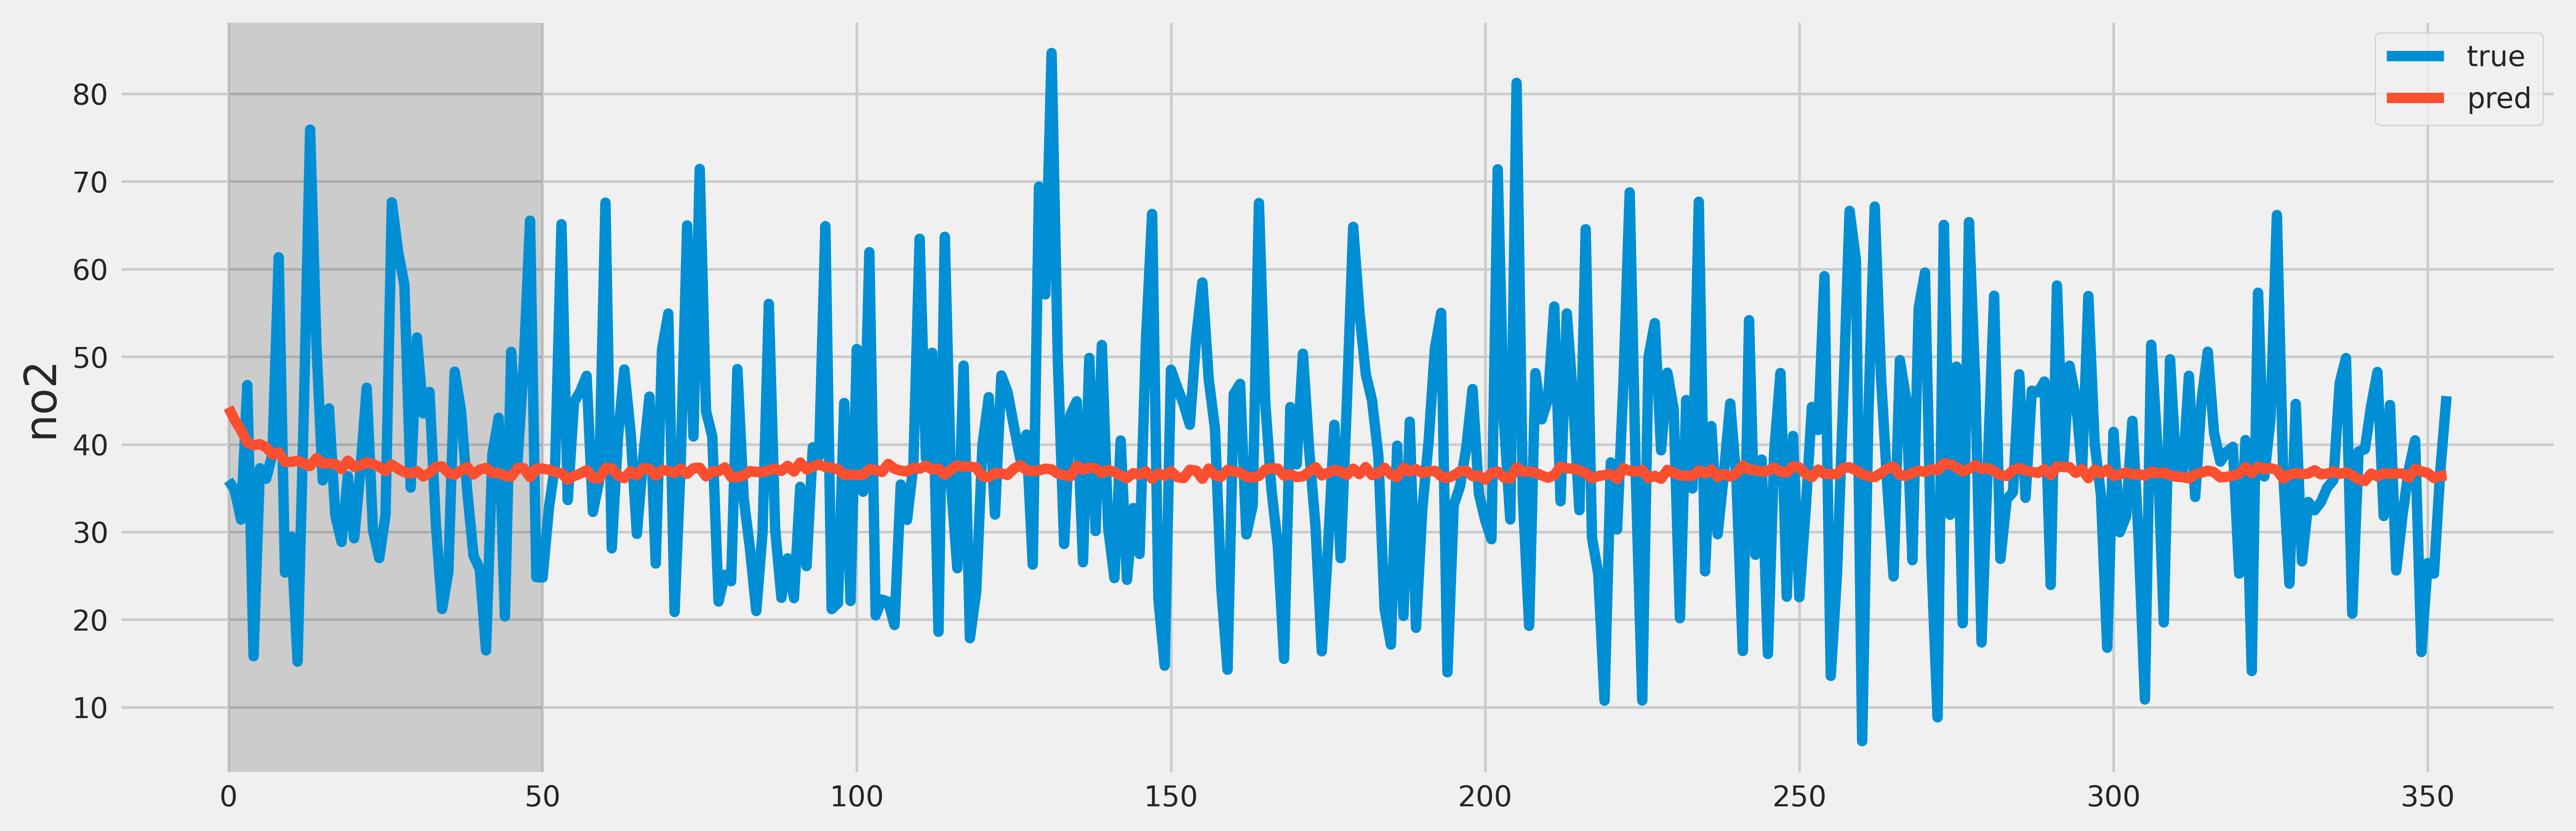

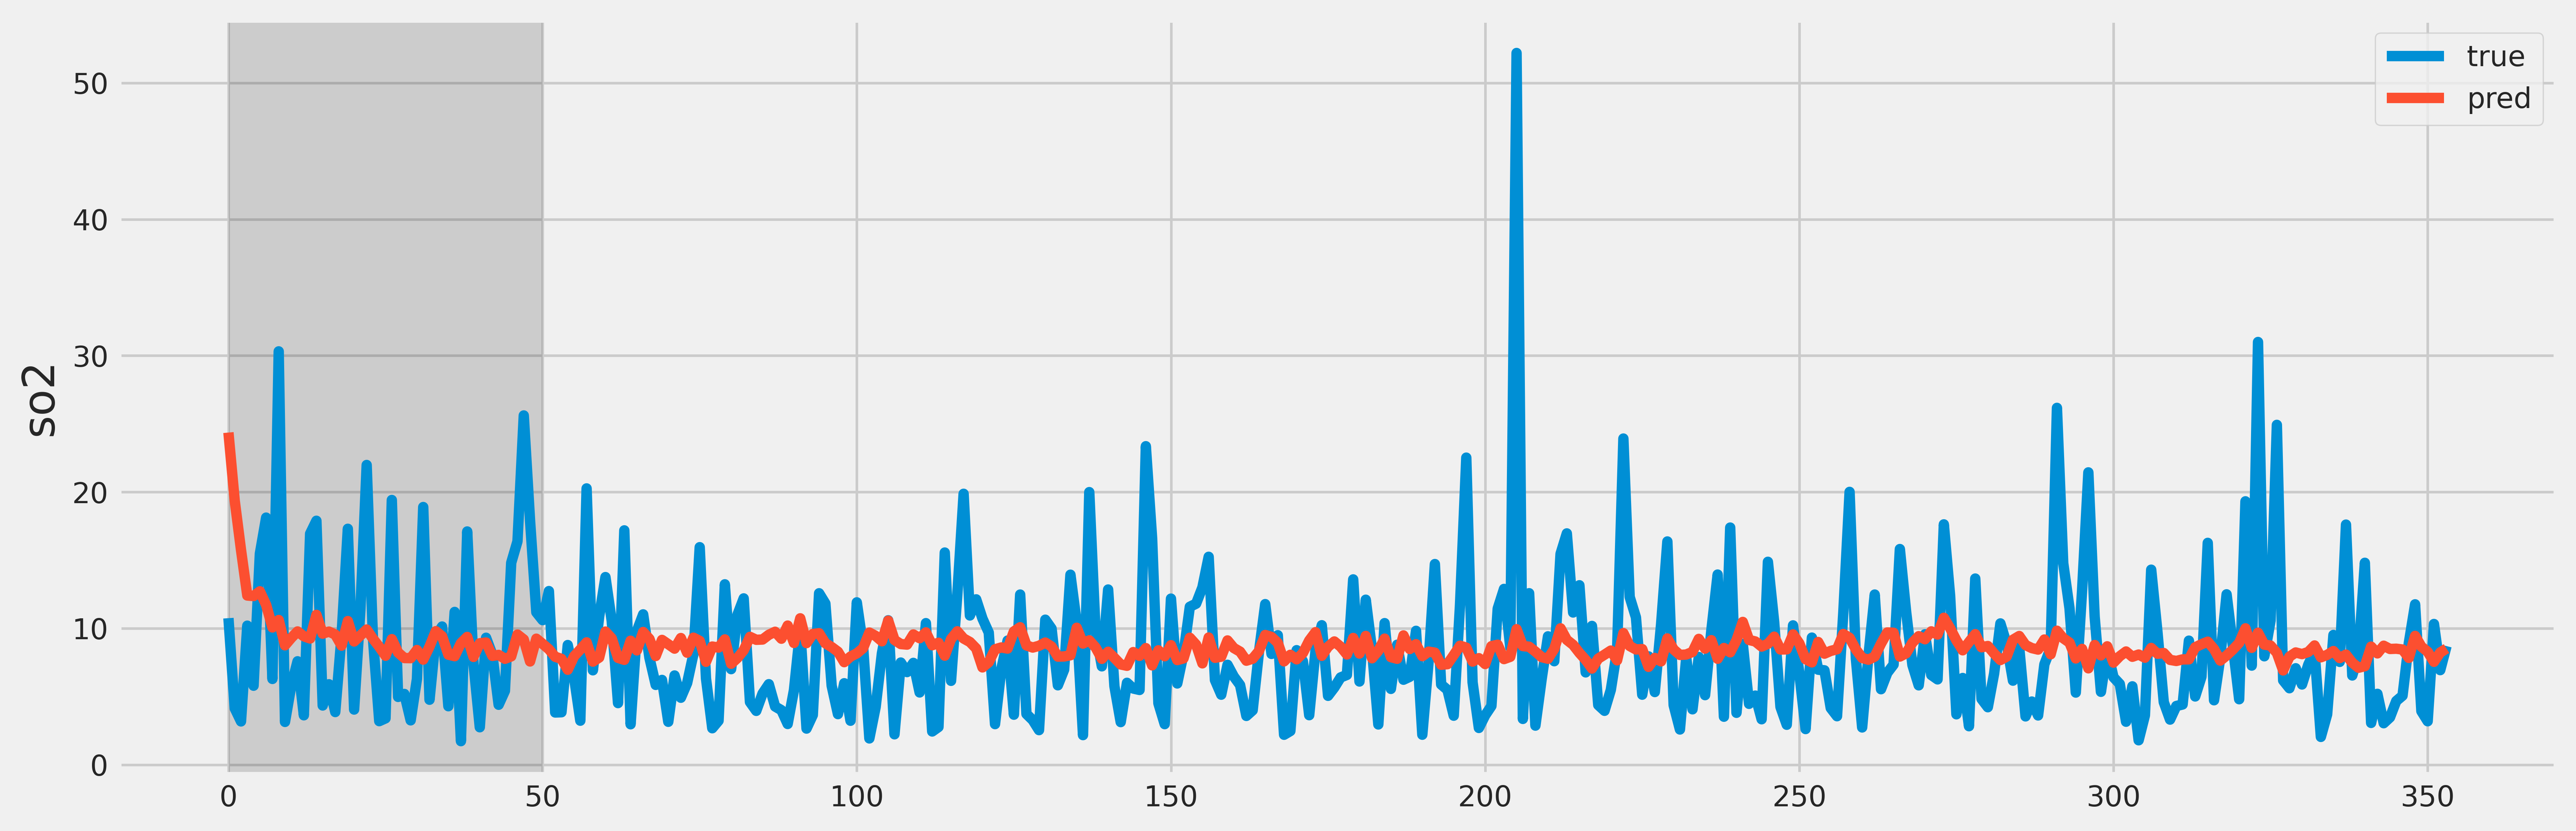

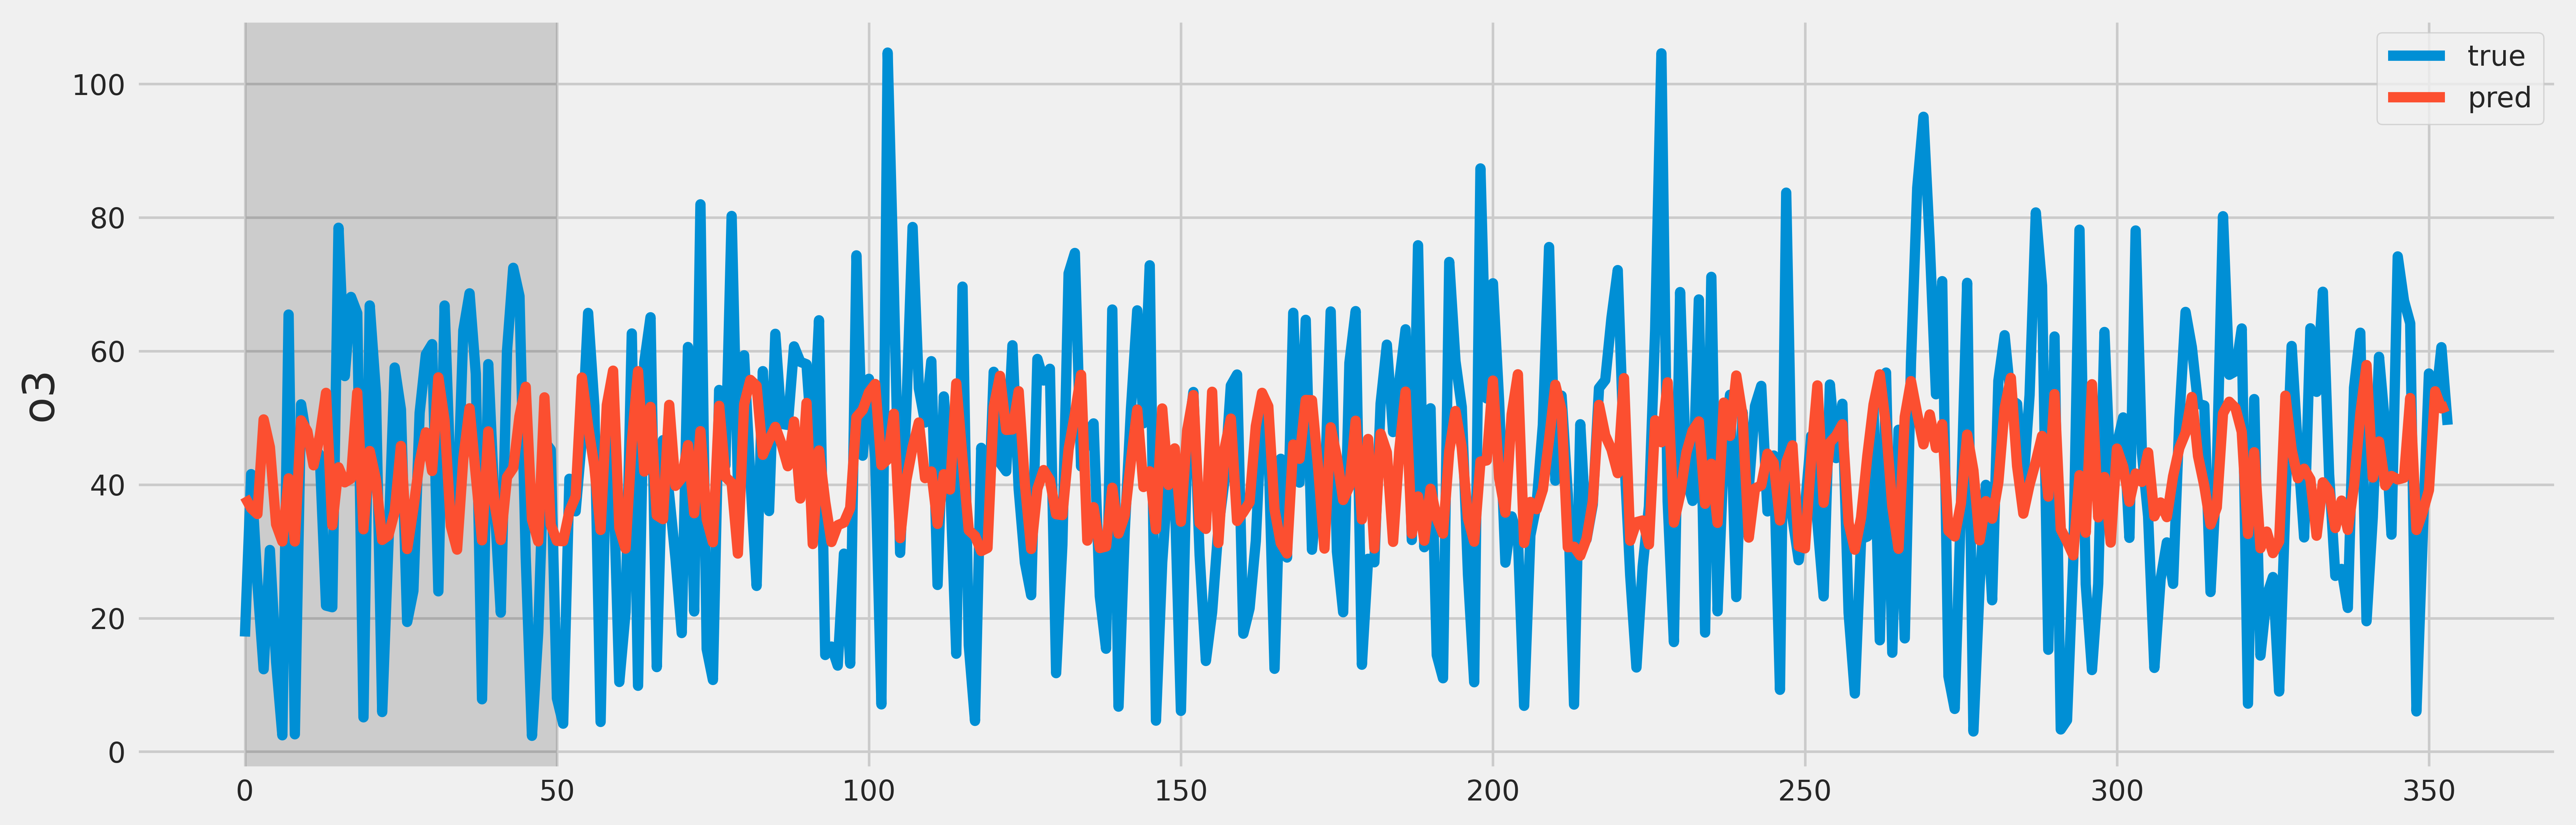

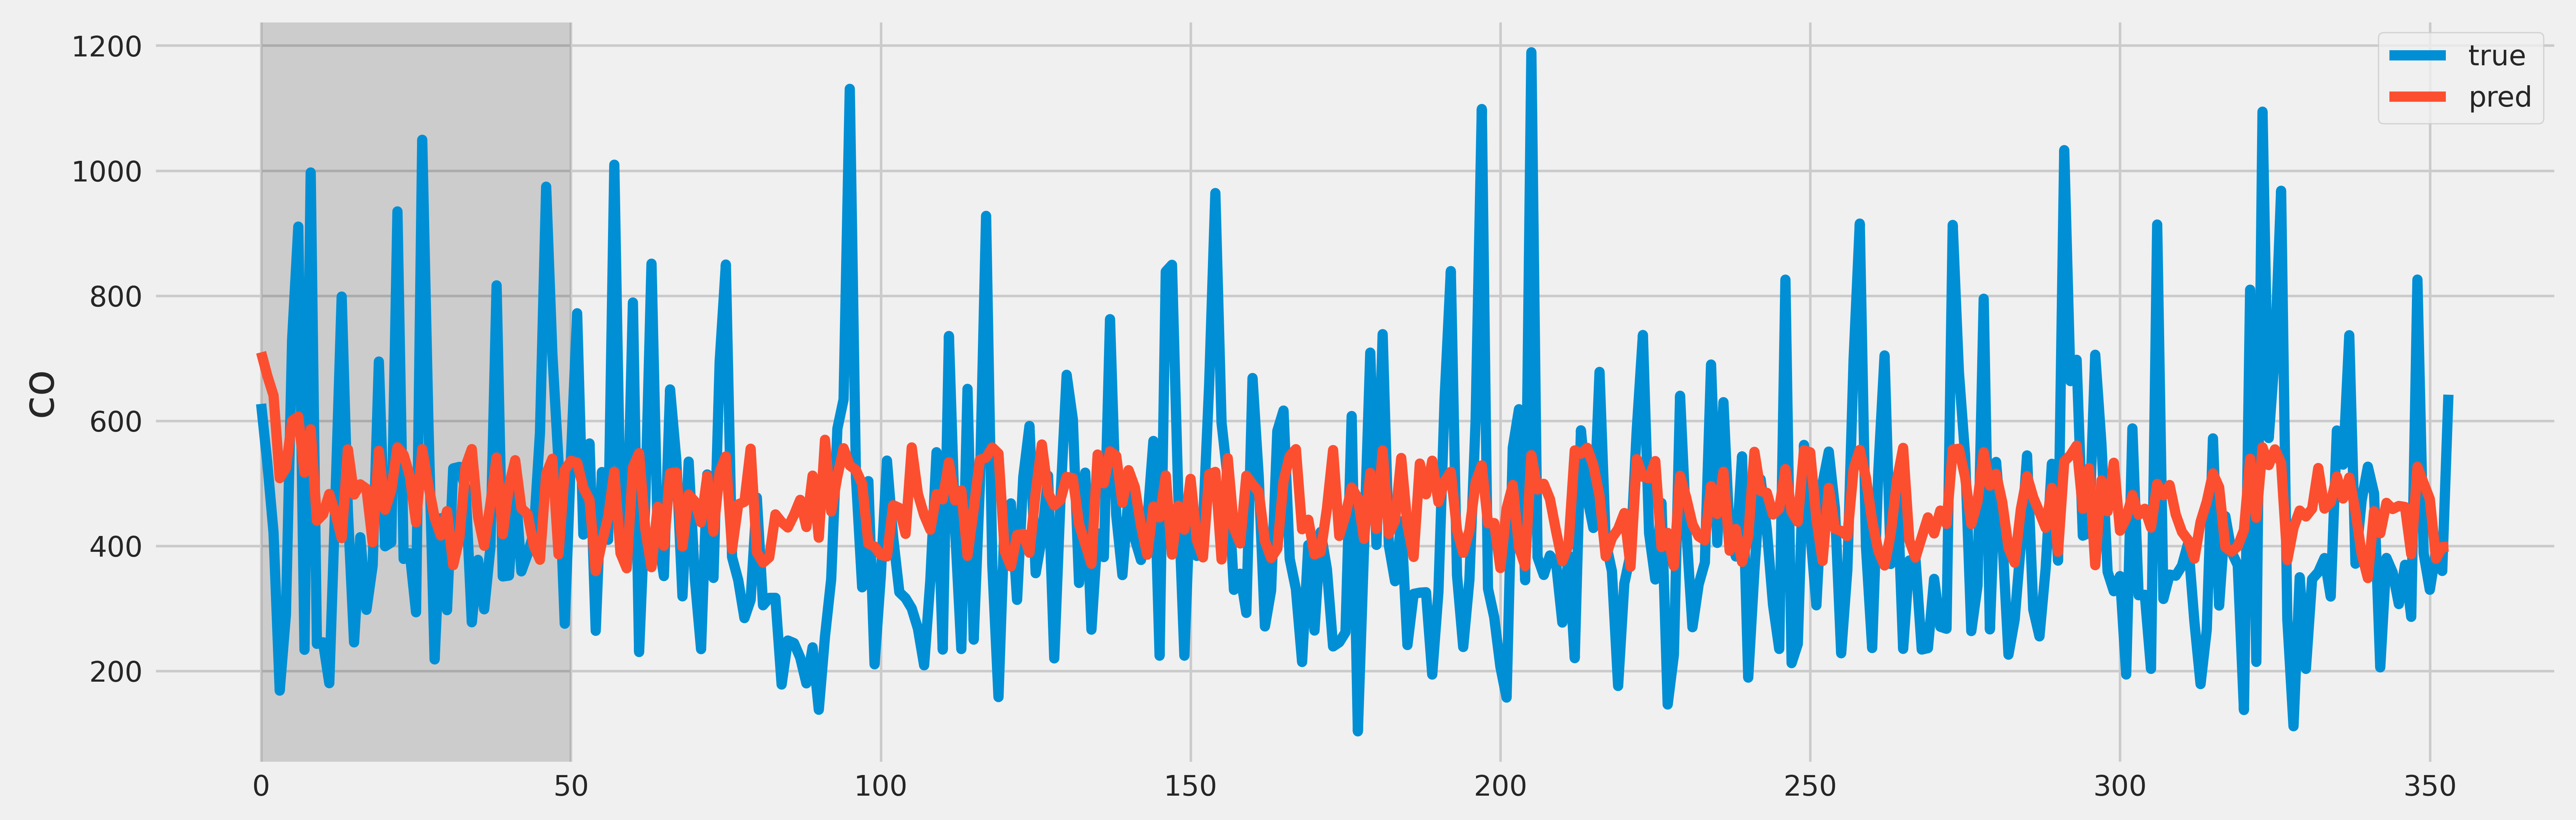

In [ ]:
plot_comparison(start_idx=0, length=354, train=True)